# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DoE.
    

## Step 0: Import Pyomo and Pyomo.DoE module

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import pyomo.common.unittest as unittest
#from pyomo.contrib.doe import DesignOfExperiments, Measurements
from doe import DesignOfExperiments
from measurements import Measurements, SpecialSet, DesignVariables

In [2]:
## check if ipopt available 

ipopt_available = pyo.SolverFactory('ipopt').available()

if not (ipopt_available):
    raise RuntimeError('This Pyomo.DoE example requires Ipopt.')

In [3]:
kitty = {"a": 5, "b": 5}
print(type(kitty.keys()))

<class 'dict_keys'>


## Step 1: Import Reaction Example Mathematical Model

Consider two chemical reactions that convert molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goal is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmaceuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like to perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concentrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [4]:
# The model is implemented in reactor_kinetics.py 
#from pyomo.contrib.doe.example.reactor_kinetics import create_model, disc_for_measure
from reactor_kinetics import create_model, disc_for_measure

## Step 2: Define inputs

In [5]:
# Create model function
createmod = create_model

# discretization by Pyomo.DAE
disc = disc_for_measure

# Control time set [h]
t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    
# Measurement time points [h]
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

# design variable and its control time set
#dv_pass = {'CA0': [0],'T': t_control}

# Define parameter nominal value 
parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}

In [6]:
# Create measurement object
### Way 1: User define measurements 
#response = ['CA','CB','CC']
#all_idx = [response]
#t_idx = t_control

#measure = {'C': [all_idx, t_idx]}

#m_res = []
#for r in response:
#    for t in t_control:
#        m_res.append(str('C['+str(r)+','+str(t)+']'))
        
#print(m_res)

#measure_class = Measurements()
#measure_class.specify(m_res)

#print(measure_class.measurement_name)
        
### Way 2: Pyomo.DoE define measurements. Measurements have at most 1 index besides the time index
total_name = ["C"]
extra_index = [[["CA", "CB", "CC"]]]
time_index = [t_control] 

#measure_gen = SpecialSet()
#measure_gen.add_elements(total_name, extra_index = extra_index, time_index = time_index)

measure_class = Measurements()
measure_class.add_elements(total_name, extra_index=extra_index, time_index = time_index)
print(measure_class.measurement_name)
print(measure_class.variance)


['C[CA,0]', 'C[CA,0.125]', 'C[CA,0.25]', 'C[CA,0.375]', 'C[CA,0.5]', 'C[CA,0.625]', 'C[CA,0.75]', 'C[CA,0.875]', 'C[CA,1]', 'C[CB,0]', 'C[CB,0.125]', 'C[CB,0.25]', 'C[CB,0.375]', 'C[CB,0.5]', 'C[CB,0.625]', 'C[CB,0.75]', 'C[CB,0.875]', 'C[CB,1]', 'C[CC,0]', 'C[CC,0.125]', 'C[CC,0.25]', 'C[CC,0.375]', 'C[CC,0.5]', 'C[CC,0.625]', 'C[CC,0.75]', 'C[CC,0.875]', 'C[CC,1]']
{'C[CA,0]': 1, 'C[CA,0.125]': 1, 'C[CA,0.25]': 1, 'C[CA,0.375]': 1, 'C[CA,0.5]': 1, 'C[CA,0.625]': 1, 'C[CA,0.75]': 1, 'C[CA,0.875]': 1, 'C[CA,1]': 1, 'C[CB,0]': 1, 'C[CB,0.125]': 1, 'C[CB,0.25]': 1, 'C[CB,0.375]': 1, 'C[CB,0.5]': 1, 'C[CB,0.625]': 1, 'C[CB,0.75]': 1, 'C[CB,0.875]': 1, 'C[CB,1]': 1, 'C[CC,0]': 1, 'C[CC,0.125]': 1, 'C[CC,0.25]': 1, 'C[CC,0.375]': 1, 'C[CC,0.5]': 1, 'C[CC,0.625]': 1, 'C[CC,0.75]': 1, 'C[CC,0.875]': 1, 'C[CC,1]': 1}


In [7]:
total_name = ["CA0", "T"]
dtime_index = [[0], t_control] 
exp1 = [5, 570, 300, 300, 300, 300, 300, 300, 300, 300]
upper_bound = [5, 700, 700, 700, 700, 700, 700, 700, 700, 700]
lower_bound = [1, 300, 300, 300, 300, 300, 300, 300, 300, 300]

design_gen = DesignVariables()
design_gen.add_elements(total_name, time_index = dtime_index, values=exp1)
design_gen.add_bounds(upper_bound=upper_bound, lower_bound=lower_bound)

In [8]:
def generate_exp(t_set, CA0, T):  
    """Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    """
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [9]:
# empty prior
prior_pass = np.zeros((4,4))

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))

The prior information FIM: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Prior Det: 0.0
Eigenvalue of the prior experiments FIM: [0. 0. 0. 0.]


## Method: Compute FIM 

This method computes an MBDoE optimization problem with no degrees of freedom.

In [10]:
# choose from 'sequential_finite', 'direct_kaug'
# 'sequential_sipopt', 'sequential_kaug' is also available
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

if sensi_opt == 'direct_kaug':
    args1 = [True]
    
# Define experiments
#exp1 = generate_exp(t_control, 5, [570, 300, 300, 300, 300, 300, 300, 300, 300])
exp1 = [5, 570, 300, 300, 300, 300, 300, 300, 300, 300]

design_gen.update_values(exp1)

In [11]:
doe_object = DesignOfExperiments(parameter_dict, design_gen,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc,)


result = doe_object.compute_FIM(design_gen, mode=sensi_opt, FIM_store_name = 'dynamic.csv', 
                                 read_output=None,
                                scale_nominal_param_value=True,
                                formula='central')


result.calculate_FIM(doe_object.design_values)


Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

In [12]:
print(doe_object.jac)

{'A1': [0.0, -1.3466945108302435, -1.0392959715043364, -0.7733119805419901, -0.5608180637832934, -0.39904340269907723, -0.27979467084814263, -0.19390454861829623, -0.1331093893670984, 0.0, 0.019915263654375348, -0.27282830625953575, -0.4952855599092672, -0.6436377585939456, -0.7284031386978062, -0.7640656221482424, -0.7644777577459819, -0.7411661149139127, 0.0, 1.3267792471758684, 1.3121242777638722, 1.2685975404512575, 1.204455822377239, 1.1274465413968837, 1.0438602929963852, 0.9583823063642781, 0.8742755042810111], 'A2': [0.0, 5.761025854469284e-15, 3.2185884979920135e-14, 4.495428497066181e-14, 3.139400607571054e-14, 6.577239198387636e-14, -7.102869656505757e-12, -4.426638023600688e-12, -2.7413571624791633e-12, 0.0, -1.375203297497099, -1.3874026640357446, -1.4015557805599772, -1.4096891620101561, -1.4082699209343343, -1.396316795964867, -1.374249965002377, -1.3431989121409162, 0.0, 1.3752032974970934, 1.3874026640357124, 1.4015557805599324, 1.4096891620101253, 1.4082699209342686, 

In [13]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

======Result summary======
Four design criteria log10() value:
A-optimality: 2.7885870986652654
D-optimality: 2.821840916615292
E-optimality: -1.012346942444497
Modified E-optimality: 3.7814034299111086


In [14]:
sub_name = ["C"]
sub_extra_index = [[["CB", "CC"]]]
sub_time_index = [[0.125, 0.25, 0.5, 0.75, 0.875]] 

measure_subset = Measurements()
measure_subset.add_elements(sub_name, extra_index=sub_extra_index, time_index=sub_time_index)
print(measure_subset.measurement_name)

['C[CB,0.125]', 'C[CB,0.25]', 'C[CB,0.5]', 'C[CB,0.75]', 'C[CB,0.875]', 'C[CC,0.125]', 'C[CC,0.25]', 'C[CC,0.5]', 'C[CC,0.75]', 'C[CC,0.875]']


In [15]:
sub_result = result.subset(measure_subset)
sub_result.calculate_FIM(doe_object.design_values)
print('======Subset Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(sub_result.trace))
print('D-optimality:', np.log10(sub_result.det))
print('E-optimality:', np.log10(sub_result.min_eig))
print('Modified E-optimality:', np.log10(sub_result.cond))

======Subset Result summary======
Four design criteria log10() value:
A-optimality: 2.5532440507351866
D-optimality: 1.3437392449897962
E-optimality: -1.539761172157351
Modified E-optimality: 4.084260887750039


## Method: Optimization
Gradient-based optimization with IPOPT with .optimize_doe()

This function solves twice: It solves the square version of the MBDoE problem first, and then unfixes the design variables as degree of freedom and solves again. In this way the optimization problem can be well initialized. 

In [ ]:
#exp1 = generate_exp(t_control, 3, [500, 300, 300, 300, 300, 300, 300, 300, 300])

exp1 = [5, 570, 300, 300, 300, 300, 300, 300, 300, 300]
design_gen.update_values(exp1)

# add a prior information (scaled FIM with T=500 and T=300 experiments)
prior = np.asarray([[  28.67892806 ,   5.41249739 , -81.73674601 , -24.02377324],
 [   5.41249739 ,  26.40935036 , -12.41816477 , -139.23992532],
 [ -81.73674601 , -12.41816477 , 240.46276004 ,  58.76422806],
 [ -24.02377324 , -139.23992532 ,  58.76422806 , 767.25584508]])



In [ ]:
doe_object = DesignOfExperiments(parameter_dict, design_gen,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)

square_result, optimize_result= doe_object.stochastic_program(design_gen, if_optimize=True, if_Cholesky=True, 
                                                         scale_nominal_param_value=True, objective_option='det', 
                                                         L_initial=np.linalg.cholesky(prior))

In [ ]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('The result FIM is:', optimize_result.FIM)
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(optimize_result.trace))
print('D-optimality:', np.log10(optimize_result.det))
print('E-optimality:', np.log10(optimize_result.min_eig))
print('Modified E-optimality:', np.log10(optimize_result.cond))

#t_list = []
#for t in optimize_result.model.t:
#    t_list.append(t)

#T_list = []
#for i in range(len(design_gen.special_set)):
#    T_list.append(pyo.value(optimize_result.model.T[i]))
    
#si=16
#plt.rc('axes', titlesize=si)
#plt.rc('axes', labelsize=si)
#plt.rc('xtick', labelsize=si)
#plt.rc('ytick', labelsize=si)
#plt.rc('legend', fontsize=12)
#plt.plot(t_list, T_list, 'b', linewidth=2)
#plt.scatter(t_list, T_list, 'b')
#plt.ylabel('T [$K$]')
#plt.xlabel('Time [$h$]')
#plt.show()

## Method: Exploratory analysis (Enumeration)

This method conducts exploratory analysis by enumeration. 
It allows a user to define any number (dimensions) of design variables.
Heatmaps can be drawn by two design variables, fixing other design variables; 
1D curve can be drawn by one design variable, fixing other design variables.

### Specify user inputs

In [16]:
# Design variable ranges as lists 
design_ranges = [list(np.linspace(1,5,3)), list(np.linspace(300,700,3))]

# Design variable names 
dv_apply_name = ['CA0[0]',['T[0]','T[0.125]','T[0.25]','T[0.375]','T[0.5]','T[0.625]','T[0.75]','T[0.875]','T[1]']]

## choose from 'sequential_finite', 'direct_kaug'
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

In [17]:
# add prior information
prior_all = [[ 22.52943024 , 1.84034314, -70.23273336, -11.09432962],
 [   1.84034314 ,  18.09848116 ,  -5.73565034 , -109.15866135],
 [ -70.23273336 ,  -5.73565034 , 218.94192843 ,  34.57680848],
 [ -11.09432962 , -109.15866135 ,  34.57680848 ,  658.37644634]]

print(np.shape(prior_all))

prior_pass=np.asarray(prior_all)
print(np.shape(prior_pass))

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))

(4, 4)
(4, 4)
The prior information FIM: [[  22.52943024    1.84034314  -70.23273336  -11.09432962]
 [   1.84034314   18.09848116   -5.73565034 -109.15866135]
 [ -70.23273336   -5.73565034  218.94192843   34.57680848]
 [ -11.09432962 -109.15866135   34.57680848  658.37644634]]
Prior Det: 1.9558434466145787e-08


In [18]:
doe_object = DesignOfExperiments(parameter_dict, design_gen,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc,)

all_fim = doe_object.run_grid_search(design_gen, design_ranges, dv_apply_name, 
                                     mode=sensi_opt)

### 1D sensitivity curve

['CA0[0]', 'T[0]', 'A', 'D', 'E', 'ME']


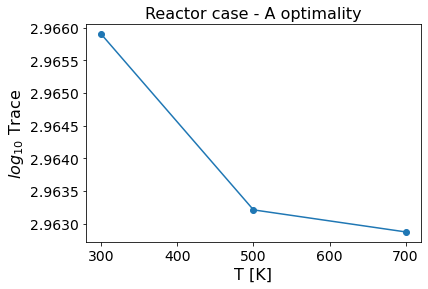

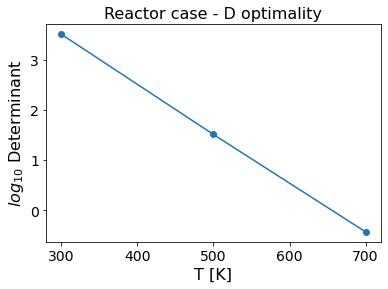

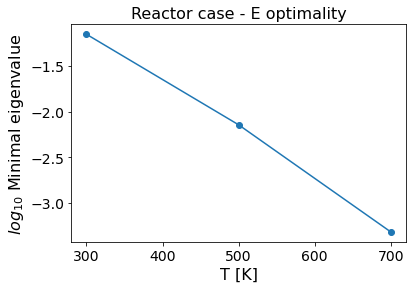

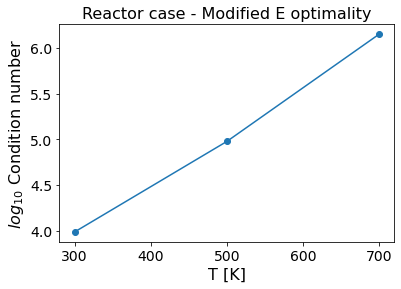

In [19]:
all_fim.extract_criteria()
#print(all_fim.store_all_results_dataframe)
## draw 1D sensitivity curve 

fixed = {"'CA0[0]'": 5.0}

all_fim.figure_drawing(fixed, ['T[0]'], 'Reactor case','T [K]','$C_{A0}$ [M]' )



In [20]:
print(all_fim.store_all_results_dataframe.loc[all_fim.store_all_results_dataframe['CA0[0]']==5.0])

   CA0[0]   T[0]           A            D         E            ME
6     5.0  300.0  924.479230  3208.099624  0.070556  9.672612e+03
7     5.0  500.0  918.783904    32.403005  0.007185  9.465707e+04
8     5.0  700.0  918.071472     0.372555  0.000482  1.411458e+06


## Heatmap

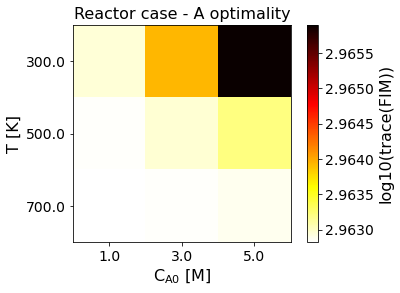

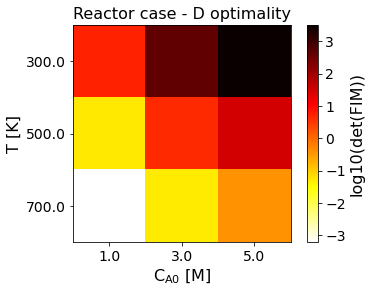

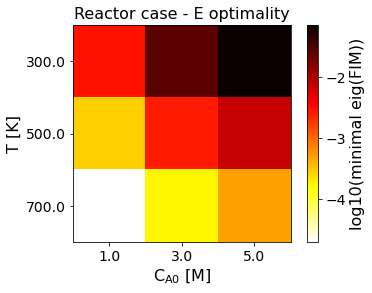

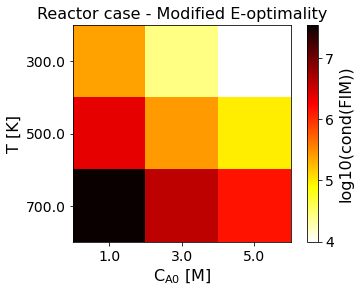

In [21]:
fixed = {}
all_fim.figure_drawing(fixed, ['CA0[0]','T[0]'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

### Read Heatmaps

A heatmap shows the change of the objective function, a.k.a. the experimental information content, in the design region. Horizontal and vertical axes are two design variables, while the color of each grid shows the experimental information content. Taking the Fig. Reactor case - A optimality as example, A-optimality shows that the most informative region is around $C_{A0}=5.0$ M, $T=300.0$ K, while the least informative region is around $C_{A0}=1.0$ M, $T=700.0$ K.

## Grid search for 3 design variables

In [ ]:
# Define design ranges
design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

# Design variable names 
dv_apply_name = ['CA0[0]','T[0]',['T[0.125]','T[0.25]','T[0.375]','T[0.5]','T[0.625]','T[0.75]','T[0.875]','T[1]']]

# Define experiments
exp1 = [5, 300, 300, 300, 300, 300, 300, 300, 300, 300]

## choose from 'sequential_finite', 'direct_kaug'
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, design_gen,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc,)

all_fim = doe_object.run_grid_search(design_gen, design_ranges, dv_apply_name, 
                                     mode=sensi_opt)

### Draw 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

In [ ]:
## draw 1D sensitivity curve 

fixed = {"'CA0[0]'": 1.0, "'T[0.125]'": 300}

all_fim.figure_drawing(fixed, ['T[0]'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

### Draw 2D sensitivity curve

In [ ]:
fixed = {"'T[0.125]'": 300}

all_fim.figure_drawing(fixed, ['CA0[0]','T[0]'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )